In [406]:
import csv
from collections import  defaultdict,Counter
import pandas as pd
import numpy as np
from random import random,choice,randint,uniform
import heapq


In [407]:

with open('studentCourse.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    d = defaultdict(list)
    dict2 = defaultdict(list)
    for row in csv_reader:
        if line_count != 0:
            d[row[1]].append(row[2])
            dict2[row[2]].append(row[1])   
        line_count += 1


# all student names       
students = list(d.keys())
# list of all courses  
courses = list(dict2.keys())


teachers = set()
with open('teachers.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    for row in csv_reader:
      teachers.add(row[0])

# list of all teachers 
teachers = list(teachers)


# list of all rooms
rooms = ['1','2','3','4','5','6','7','8','9','10']

num_rooms = len(rooms)
num_students = len(students)
num_teachers = len(teachers)
num_courses = len(courses)



days = 5 
num_slots_in_day = 2
time = ['Monday    \tWeek-1 9AM-12PM','Monday    \tWeek-1 2PM-5PM','Tuesday   \tWeek-1 9AM-12PM','Tuesday   \tWeek-1 2PM-5PM','Wednesday \tWeek-1 9AM-12PM',
        'Wednesday \tWeek-1 2PM-5PM','Thursday  \tWeek-1 9AM-12PM','Thursday  \tWeek-1 2PM-5PM','Friday    \tWeek-1 9AM-12PM','Friday    \tWeek-1 2PM-5PM',
        #second weeek
        'Monday    \tWeek-2 9AM-12PM','Monday    \tWeek-2 2PM-5PM','Tuesday   \tWeek-2 9AM-12PM','Tuesday   \tWeek-2 2PM-5PM','Wednesday \tWeek-2 9AM-12PM',
        'Wednesday \tWeek-2 2PM-5PM','Thursday  \tWeek-2 9AM-12PM','Thursday  \tWeek-2 2PM-5PM','Friday    \tWeek-2 9AM-12PM','Friday    \tWeek-2 2PM-5PM',
        #third week
        'Monday    \tWeek-3 9AM-12PM','Monday    \tWeek-3 2PM-5PM',
        'Tuesday   \tWeek-3 9AM-12PM','Tuesday   \tWeek-3 2PM-5PM' #,'Wednesday \tWeek-3 9AM-12PM','Wednesday \tWeek-3 2PM-5PM',
        #'Thursday  \tWeek-3 9AM-12PM','Thursday  \tWeek-3 2PM-5PM','Friday    \tWeek-3 9AM-12PM','Friday    \tWeek-3 2PM-5PM'
        
        ]




**Miscellaneous for fitness function**

In [408]:

# FUNCTION TO CHECK THAT GIVEN TWO TIMESLOTS ARE CONSECUTIVE or not (on same day)
def consecutive_slots(time1,time2):
  set1 = set(time1.split(' '))
  set2 = set(time2.split(' '))
  x = set1.symmetric_difference(set2)
  if x == {'2PM-5PM', '9AM-12PM'}:
    return True
  return 0

# decaring two dictionaries
clashes = {}
clash_free = {}

# setting their keys with courses and setting values with empty lists
for i in courses:
  clashes[i] = []
  clash_free[i] = []

# dict2 is the dictionary with subject as key and students as values
# d is the dictionary with student as key and subjects as values 
# from these two dictionaries we made the deictionary clashes
# clashes has subject as key and its value is the list that contains all other subjects which its students are studying
# for example  if Ali is taking NLP , AI , PDC , ALGO
# then clashes['NLP'] = [AI,PDC,ALGO,NLP]
# similarly clashes['AI'] = [PDC,NLP,ALGO,AI]
# if we want to check number of clashes of subject X then 
# number of clashes of X = len(clashes['X']) - 1 (-1 because the name of the subject is also in the list)


for std in students:
  for course in courses:
    if std in list(dict2[course]):
      if course in list(clashes.keys()):
       for x in list(d[std]):
         if x not in list(clashes[course]):
           clashes[course].append(x)

# taking difference between set of courses and set of clashes per subject  
# by taking this difference we also deleted the name of subject itself 
# and clash_free just has the list with name of subject which is clash free with it

for i,j in clashes.items():
  clash_free[i] = list(set(courses).symmetric_difference(set(clashes[i])))



# **Chromosome** : *Exam_Slot* : course , Room , Invigilator , Time


In [409]:
class Exam_Slot(object):
  def __init__(self,rooms,teachers,time,courses='-'):
    self.room = rooms
    self.invigilator = teachers
    self.time = time
    self.course = courses
    self.done = False 

  def __repr__(self):
      return str('{:10s} {:30s} {:5s} {:30s}'.format(self.course,self.invigilator,self.room,self.time))

#############################################################################################
course_list = []

class chromosome():
  def __init__(self):
    self.timetable  = [Exam_Slot(choice(rooms),choice(teachers),choice(time)) for j in range(len(courses))]
    for exam in self.timetable:
        selected_course = choice(courses) 
        while True:
          if selected_course not in course_list:
            course_list.append(selected_course)
            if len(course_list) == len(courses):
              course_list.clear()
            break
          else:
            selected_course = choice(courses)
        exam.course = selected_course
    self.fitness = 0
    self.assigned_rooms = set()
    self.assigned_teachers = set()
    
    for i in range (len(courses)):
      self.assigned_teachers.add(self.timetable[i].invigilator)
      self.assigned_rooms.add(self.timetable[i].room)
    
    self.clashfree = False
    self.CLASH_TEACHER = 0
    self.UNBALANCE_DUTY = 0
    self.ROOM_CLASH = 0
    self.CONSECUTIVE_DUTY = 0
    self.CLASH_TIME = 0
    


  def __repr__(self):
    fitness = "Fitness :- " + str(self.fitness) + '\n'
    label = str('{:10s} {:30s} {:5s} {:30s} '.format('Course','Invigilator','Room','Day \t\tWeek-StartHours-Endhours'))    
    startline  = "+==========================================================================================+\n"
    temp = str()
    for i in self.timetable:
      temp+=str(i)
      temp+='\n'
    endline = "+==========================================================================================+\n"
    return str(fitness + label+'\n'+startline+ temp + endline)

  def calculate_fitness(self):
    self.CLASH_TEACHER = 0
    self.UNBALANCE_DUTY = 0
    self.ROOM_CLASH = 0
    self.CONSECUTIVE_DUTY = 0
    self.CLASH_TIME = 0
    for i in range(len(self.timetable)):
      for j in range(i+1,len(self.timetable)):
        if self.timetable[i].time == self.timetable[j].time:
          if self.timetable[i].course not in clash_free[self.timetable[j].course]:
            self.CLASH_TIME +=1
            # print("CLASH TIME",end="->")
            # print(self.timetable[i].course,self.timetable[j].course)
            # constraint checking for no two exams at same time
          if self.timetable[i].room == self.timetable[j].room:
            # print("ROOM CLASH",end="->")
            # print(self.timetable[i].room,self.timetable[j].course)
            # # constraint checking for no two exams in same room
            self.ROOM_CLASH +=1
        if self.timetable[i].invigilator == self.timetable[j].invigilator:
          # print("UNBALANCE DUTY " , end='->')
          # print(self.timetable[i].invigilator)
          self.UNBALANCE_DUTY +=1
          # constraint checking for teachers duty should be divided equally
          if self.timetable[i].time == self.timetable[j].time:
            # constraint checking : A teacher cannot invigilate two exams at the same time.
            self.CLASH_TEACHER +=1
            # print("CLASH TEACHER" , end='->')
            # print(self.timetable[i].invigilator,self.timetable[j].invigilator)
          if (consecutive_slots(self.timetable[i].time,self.timetable[j].time)):
            # print("CONSECUTIVE DUTY" , end='=>')
            # print(self.timetable[i].invigilator,self.timetable[j].invigilator)
            # # constraint checking that teacher should not be invigilating for two consecutive slots in arow
            self.CONSECUTIVE_DUTY +=1
      #print("===================================")
    
    
    if (self.CLASH_TEACHER == 0 and self.UNBALANCE_DUTY == 0 and self.ROOM_CLASH == 0 and self.CONSECUTIVE_DUTY == 0 and self.CLASH_TIME == 0):
      self.clashfree = True

    if self.clashfree:
      self.fitness = 100
    else:
      self.fitness = (1/(self.CLASH_TEACHER*1 + self.CONSECUTIVE_DUTY*1 + self.UNBALANCE_DUTY*(0.5) + self.ROOM_CLASH*1 + self.CLASH_TIME*5 ))*100
    #print(self.fitness)
    #print("*****************************************************")

  def mutate(self,i):

    mutation_rate = 0.01
    # if i>150:
    #   mutation_rate = 0.02

    for i in range(len(self.timetable)):
      for j in range(i+1,len(self.timetable)):
        #if random() > mutation_rate:
        if self.timetable[i].time == self.timetable[j].time:
          if self.timetable[i].course not in clash_free[self.timetable[j].course]:
            self.timetable[j].time = choice(time)
            # constraint checking for no two exams at same time
          if self.timetable[i].room == self.timetable[j].room:
            self.timetable[j].room = choice(rooms)
            # constraint checking for no two exams in same room
        if self.timetable[i].invigilator == self.timetable[j].invigilator:
          self.timetable[i].invigilator = choice(teachers)

    self.calculate_fitness()

  def __lt__(self,other):
    return self.fitness < other.fitness


Time Sorted Representation of Timetable

In [410]:

def sorted_Time(best_timetable):
  fitness = "Fitness :- " + str(best_timetable.fitness) + '\n'
  label = str('{:10s} {:30s} {:5s} {:30s} '.format('Course','Invigilator','Room','Day \t\tWeek-StartHours-Endhours'))
  print(label)    
  print("+==========================================================================================+")
  for t in time:
    for examslot in best_timetable.timetable:
      if t == examslot.time:
        print(examslot)
  print("+==========================================================================================+")
  

**Generate Population**

In [411]:
population_size = 300
chromosomes = [chromosome() for i in range(population_size)]

**Selection**


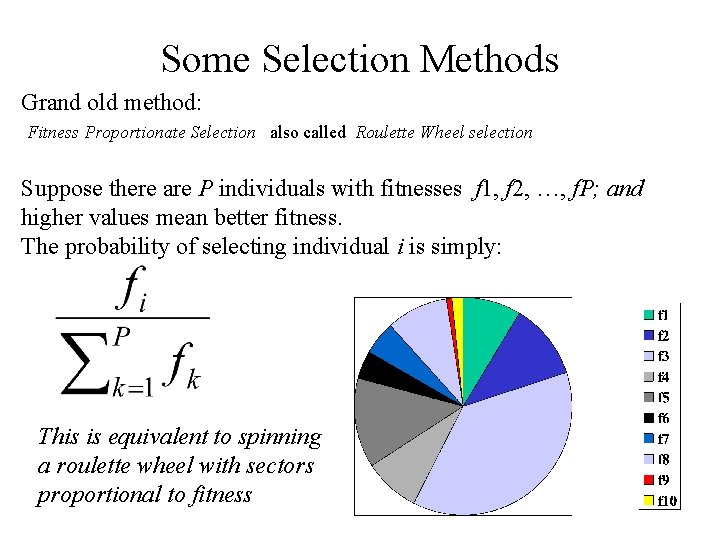



In [412]:
def roulette_select(population, fitnesses, num):
    total_fitness = float(sum(fitnesses))
    rel_fitness = [f/total_fitness for f in fitnesses]
    probs = [sum(rel_fitness[:i+1]) for i in range(len(rel_fitness))]
    new_population = []
    for n in range(num):
        r = random()
        for (i, individual) in enumerate(population):
            if r <= probs[i]:
                new_population.append(individual)
                break
    return new_population



In [413]:
def selection_by_tournament(chromosomes):
    if chromosomes[0].fitness > chromosomes[1].fitness: 
        largest = chromosomes[0]
        second_largest = chromosomes[1]
    else: 
        largest = chromosomes[1] 
        second_largest = chromosomes[0] 
   
    for chromo in chromosomes[2:]:
        if chromo.fitness > largest.fitness:
            second_largest = largest
            largest = chromo
        elif largest.fitness > chromo.fitness > second_largest.fitness:
            second_largest = chromo
    return [largest, second_largest]

**Crossover** : Time , Invigilator , Room




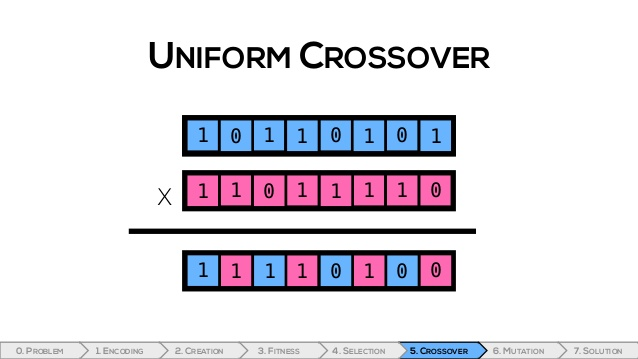

In [414]:
def crossover(father,mother):
  offspring = chromosome()
  for i in range(len(offspring.timetable)):
    #r = randint(0,1)
    if i % 2 == 0:
      offspring.timetable[i].time =  mother.timetable[i].time
      offspring.timetable[i].invigilator = mother.timetable[i].invigilator
      offspring.timetable[i].room = mother.timetable[i].room
    else:
      offspring.timetable[i].time =  father.timetable[i].time
      offspring.timetable[i].invigilator = father.timetable[i].invigilator
      offspring.timetable[i].room = father.timetable[i].room

  return offspring

**Mutation**

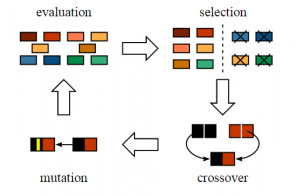

**Algorithm Implemented**


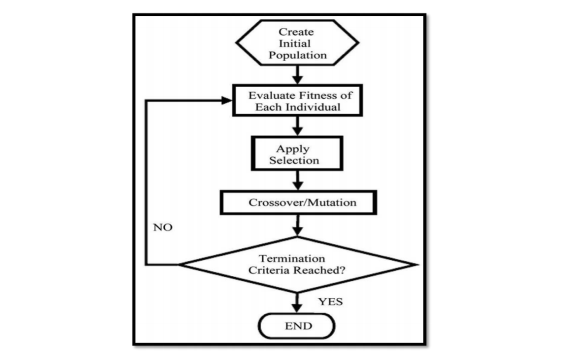

# Assumptions :

1.   Time slot is 3 hours 
2.   Room capacity is sufficient
3.   There are only 2 slots in the day
4.   Fitness with 100 value is maximum
5.   Penalty for time clash between courses is 5 times more than other penalties i-e 5 
6.   Penalty for soft constraint i-e unbalance invigilation duty is 0.5
7.   Penalty for hard constraints of teachers and rooms clash is 1

In [415]:
# Main Algorithm
def GA():
  i  = 1
  while True:
    if chromosomes[i].clashfree:
      #print(chromosomes[i])
      return chromosomes[i]
      
    print("Generation Number :- ",i , end= "     Fitness :-")
    chromosomes[i].calculate_fitness()
    print(chromosomes[i].fitness)
    if (chromosomes[i].fitness == 100 ):
      #print("Solution Found\n",chromosomes[i])
      return chromosomes[i]

    #pool = heapq.nlargest(50,chromosomes)
    fitnesses = []
    for chromo in chromosomes:
      fitnesses.append(chromo.fitness)

    parents = roulette_select(chromosomes,fitnesses,2)
    #parents = selection_by_tournament(chromosomes)
    #print(parents[0].fitness,parents[1].fitness)
    child = crossover(parents[0],parents[1])
    child.mutate(i)
    chromosomes.append(child)
    if (child.clashfree):
      #print("Solution Found\n",child)
      return child
    i+=1


In [416]:
best_timetable = GA()

Generation Number :-  1     Fitness :-2.127659574468085
Generation Number :-  2     Fitness :-1.694915254237288
Generation Number :-  3     Fitness :-2.4390243902439024
Generation Number :-  4     Fitness :-1.8518518518518516
Generation Number :-  5     Fitness :-1.7391304347826086
Generation Number :-  6     Fitness :-1.25
Generation Number :-  7     Fitness :-1.8691588785046727
Generation Number :-  8     Fitness :-1.8691588785046727
Generation Number :-  9     Fitness :-1.2903225806451613
Generation Number :-  10     Fitness :-3.076923076923077
Generation Number :-  11     Fitness :-2.2988505747126435
Generation Number :-  12     Fitness :-1.8867924528301887
Generation Number :-  13     Fitness :-1.7094017094017095
Generation Number :-  14     Fitness :-2.0618556701030926
Generation Number :-  15     Fitness :-1.9230769230769231
Generation Number :-  16     Fitness :-1.36986301369863
Generation Number :-  17     Fitness :-1.4084507042253522
Generation Number :-  18     Fitness :-1.7

In [417]:
sorted_Time(best_timetable)  # prints timetable

Course     Invigilator                    Room  Day 		Week-StartHours-Endhours 
+==========================================================================================+
CS211      Usman Ashraf                   9     Monday    	Week-1 9AM-12PM    
SS113      Maheen Arshad                  9     Tuesday   	Week-1 9AM-12PM    
DS3011     Sumera Abbas                   3     Tuesday   	Week-1 2PM-5PM     
CS302      Asma Nisa                      1     Wednesday 	Week-1 9AM-12PM    
CS218      Tayyaba Zainab                 7     Wednesday 	Week-1 2PM-5PM     
CY2012     Zainab Abaid                   9     Thursday  	Week-1 9AM-12PM    
MG223      Subhan Ullah                   10    Thursday  	Week-1 2PM-5PM     
MG220      Waqas Munir                    1     Friday    	Week-1 9AM-12PM    
SS118      Nagina Safdar                  4     Friday    	Week-1 2PM-5PM     
CS328      Arshad Islam                   6     Monday    	Week-2 9AM-12PM    
SS152      Hassan Mustafa            

In [418]:
print("Clashes Resolved :- " ,best_timetable.clashfree)
print("Total Days : ", int(len(time)/2))


Clashes Resolved :-  True
Total Days :  12


# Hard Constraints resolved : 6/6


In [419]:
print("Clash in course timings : ",best_timetable.CLASH_TIME)
print("Clash in Invigilation Duties : ",best_timetable.CLASH_TEACHER)
print("Clash in room allocation : ",best_timetable.ROOM_CLASH)

Clash in course timings :  0
Clash in Invigilation Duties :  0
Clash in room allocation :  0


# Soft Constraints resolved : 3/4

In [421]:
print("Unequal Duties for assigned teachers : ",best_timetable.UNBALANCE_DUTY)
print("Every Friday, there is break from 1pm-2pm")
print("Students donot have exams in consecutive slots")


Unequal Duties for assigned teachers :  0
Every friday, there is break from 1pm-2pm
Students donot have exams in consecutive slots
